# Install & Import all the necessary Libraries

In [1]:
! pip install -q scikeras keras-tuner
! pip install -q wandb -qqq
! pip install -q visualkeras
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-18 23:30:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-18 23:30:54 (43.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from IPython.display import display, FileLink
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras import utils, layers, backend as K, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, TensorBoard

import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import keras_tuner
from tensorflow import keras
import matplotlib.pyplot as plt

from IPython.display import FileLink
from IPython import display
import pandas as pd

from sklearn.metrics import classification_report
import cv2

from PIL import Image
import os
import shutil
from pathlib import Path

import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

import random
import wandb
from wandb.keras import WandbCallback
import tensorboard
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot
from datetime import datetime
from packaging import version
import copy
import visualkeras
from PIL import Image

import shutil

# Place the key in "UserSecrets" so that the personalized API key is not public
wandb.login(key="c948e48779b58ece6a411340f174157ed7d2de58")
! rm -rf ./logs/

print('Libraries imported.')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Libraries imported.


# Declaring Constants

In [3]:
# Training configurations
SEED_VALUE = 15
BATCH_SIZE = 32
N_EPOCH = 50
N_CLASSES = 7
VERBOSE = 1

# Original dimensions - 400 x 400
IMG_ROWS = 224
IMG_COLS = 224
IMG_CHANNELS = 3

# File paths
INPUT_DATA = "/kaggle/input/the-fabrics-dataset/"
CHECKPOINT_PATH = "/kaggle/working/best_model.hdf5"
ROOT_DIR = "/kaggle/working/"
TENSORBOARD_CLASSBACK_EXP = "/Texture Recognition/"

In [4]:
# Seeding everything
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.compat.v1.set_random_seed(SEED_VALUE)

# The Fabrics Dataset

In [5]:
# Extracting file input directory and labels
input_filepaths = []
input_labels = []

for index, fabric in enumerate(os.listdir(INPUT_DATA)):
    print("In folder {} \n".format(fabric))
    for fabric_type in os.listdir(os.path.join(INPUT_DATA, fabric)):
        for fabric_img in os.listdir(os.path.join(INPUT_DATA, fabric, fabric_type)):
            if Path(fabric_img).suffix == '.png':
                src_image = os.path.join(INPUT_DATA, fabric, fabric_type, fabric_img)
                input_filepaths.append(src_image)
                input_labels.append(fabric)

In folder Nylon 

In folder Polyester 

In folder Satin 

In folder Blended 

In folder Suede 

In folder Viscose 

In folder Denim 

In folder Artificial_fur 

In folder Crepe 

In folder Terrycloth 

In folder Acrylic 

In folder Wool 

In folder Linen 

In folder Silk 

In folder Velvet 

In folder Leather 

In folder Felt 

In folder Cotton 

In folder Chenille 



In [6]:
# Creating dataframe with the filepath and respective labels
data_df = pd.DataFrame(list(zip(input_filepaths, input_labels)), columns =['Filepath', 'Label'])
data_df

,Filepath,Label
0,/kaggle/input/the-fabrics-dataset/Nylon/1446/i...,Nylon
1,/kaggle/input/the-fabrics-dataset/Nylon/1446/i...,Nylon
2,/kaggle/input/the-fabrics-dataset/Nylon/1446/i...,Nylon
3,/kaggle/input/the-fabrics-dataset/Nylon/1446/i...,Nylon
4,/kaggle/input/the-fabrics-dataset/Nylon/1215/i...,Nylon
...,...,...
7124,/kaggle/input/the-fabrics-dataset/Chenille/863...,Chenille
7125,/kaggle/input/the-fabrics-dataset/Chenille/864...,Chenille
7126,/kaggle/input/the-fabrics-dataset/Chenille/864...,Chenille
7127,/kaggle/input/the-fabrics-dataset/Chenille/864...,Chenille


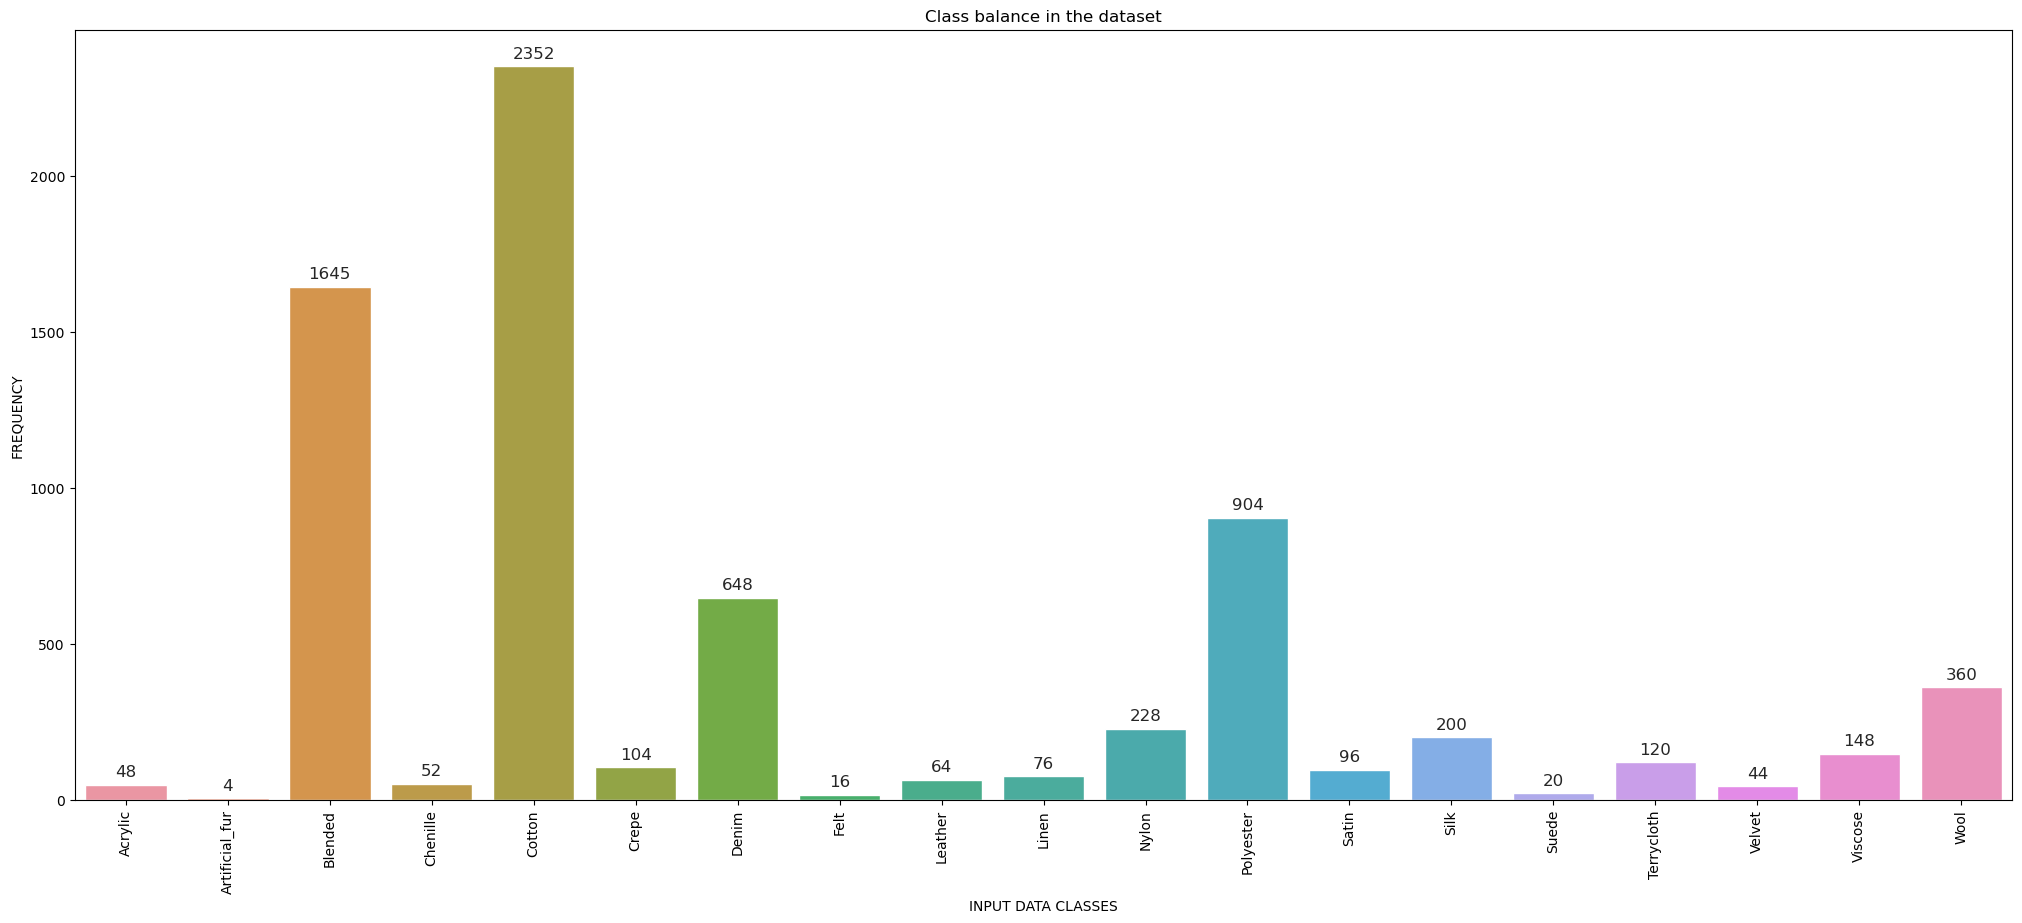

In [7]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(input_labels, return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class balance in the dataset")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

## Removing fabrics with very low sample size
Even though we perform data augmentation in the next steps, performing this operation on a very small subset does not help in generalizing the model. Hence, we remove fabric samples that have extremely low sample size
For instance, Artificial Fur only has 4 samples. Data Augmentation on such a small sample size if not helpful in improving model performance.

In [8]:
data_df = data_df.loc[data_df['Label'].isin(["Blended", "Cotton", "Denim", "Polyester", "Nylon", "Silk", "Wool"])]
data_df = data_df.reset_index(drop=True)
data_df

,Filepath,Label
0,/kaggle/input/the-fabrics-dataset/Nylon/1446/i...,Nylon
1,/kaggle/input/the-fabrics-dataset/Nylon/1446/i...,Nylon
2,/kaggle/input/the-fabrics-dataset/Nylon/1446/i...,Nylon
3,/kaggle/input/the-fabrics-dataset/Nylon/1446/i...,Nylon
4,/kaggle/input/the-fabrics-dataset/Nylon/1215/i...,Nylon
...,...,...
6332,/kaggle/input/the-fabrics-dataset/Cotton/1888/...,Cotton
6333,/kaggle/input/the-fabrics-dataset/Cotton/246/i...,Cotton
6334,/kaggle/input/the-fabrics-dataset/Cotton/246/i...,Cotton
6335,/kaggle/input/the-fabrics-dataset/Cotton/246/i...,Cotton


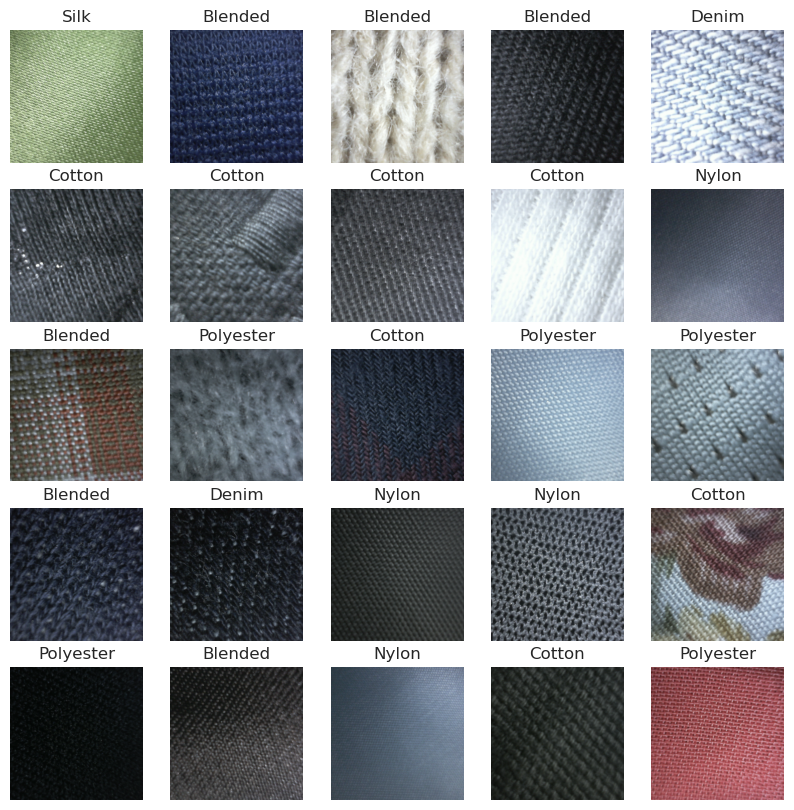

In [9]:
random_index = np.random.randint(0, len(data_df), 25)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.imshow(plt.imread(data_df.Filepath[random_index[i]]))
    ax.set_title(data_df.Label[random_index[i]])
    plt.axis('off')
plt.show()

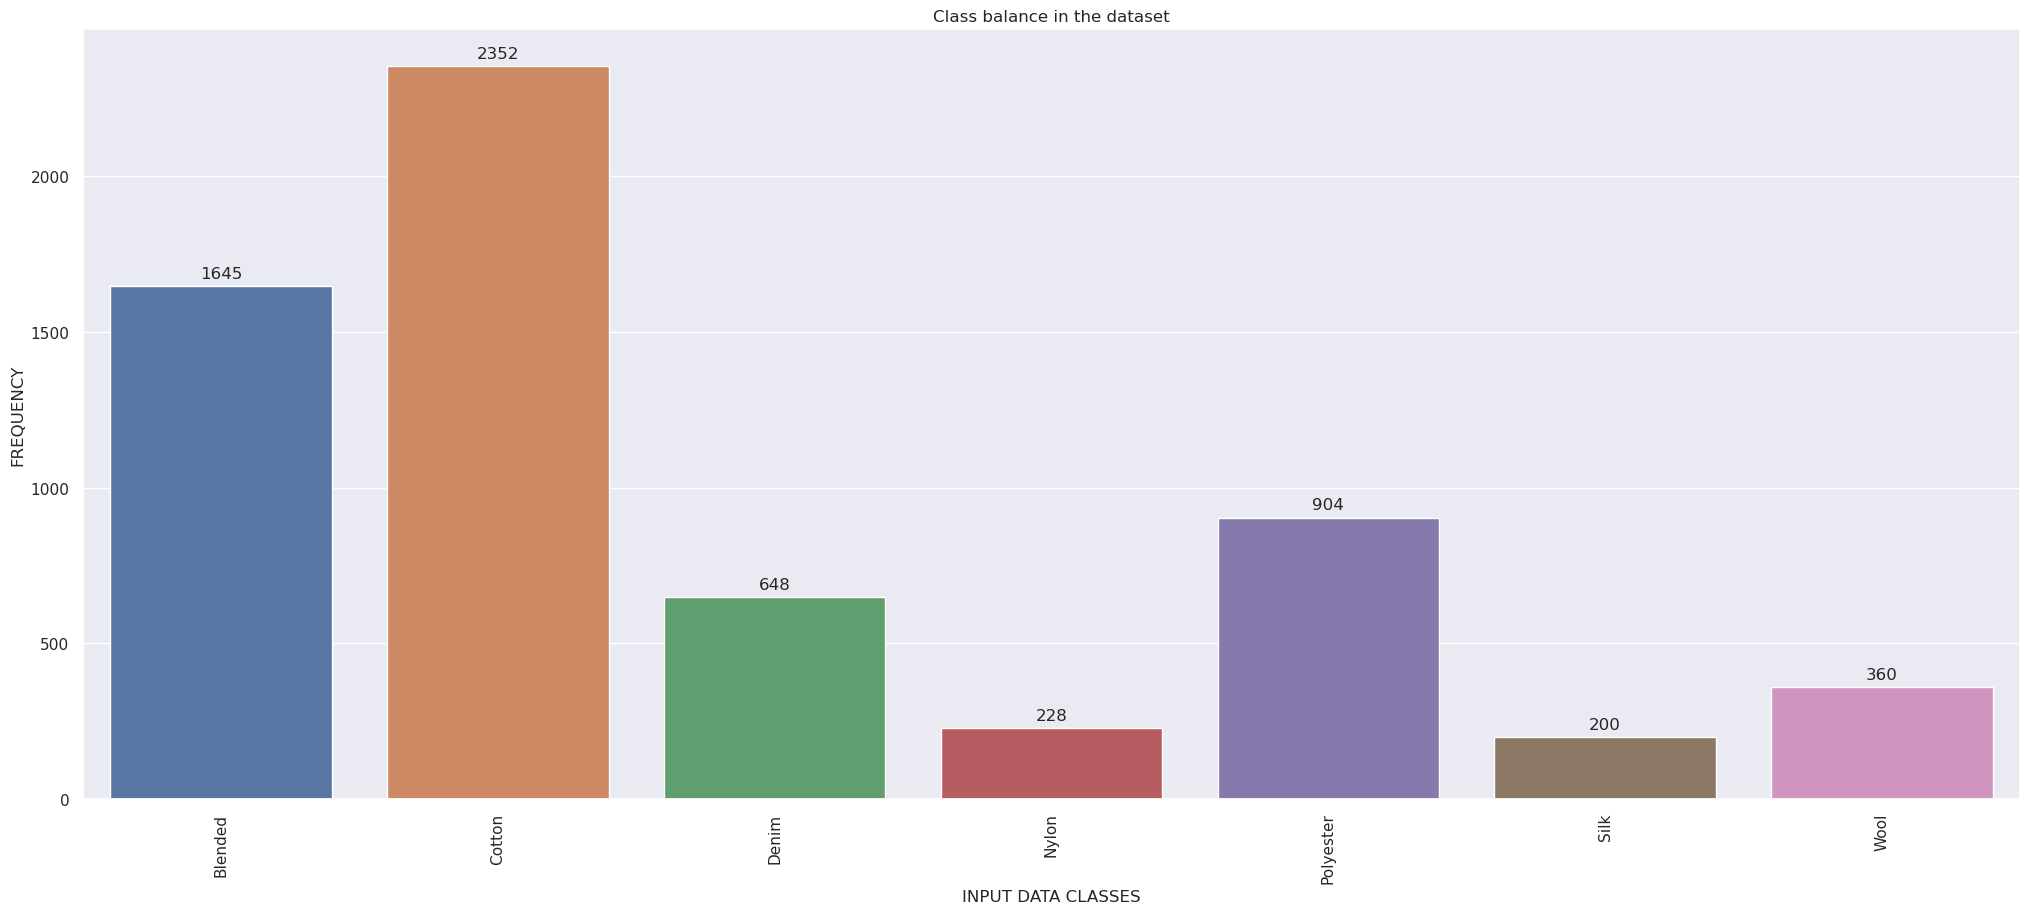

In [10]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(data_df.Label.values.tolist(), return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class balance in the dataset")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

## Improving the class balance through Data Augmentation
Multi Step Augmentation to improve class balance. We perform this augmentation only on the training data, retaining the original fabric samples in the test dataset.

In [11]:
# Splitting the data (80/20 ) into train & test datasets with stratification 
train_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df[['Label']], shuffle=True, random_state=SEED_VALUE)

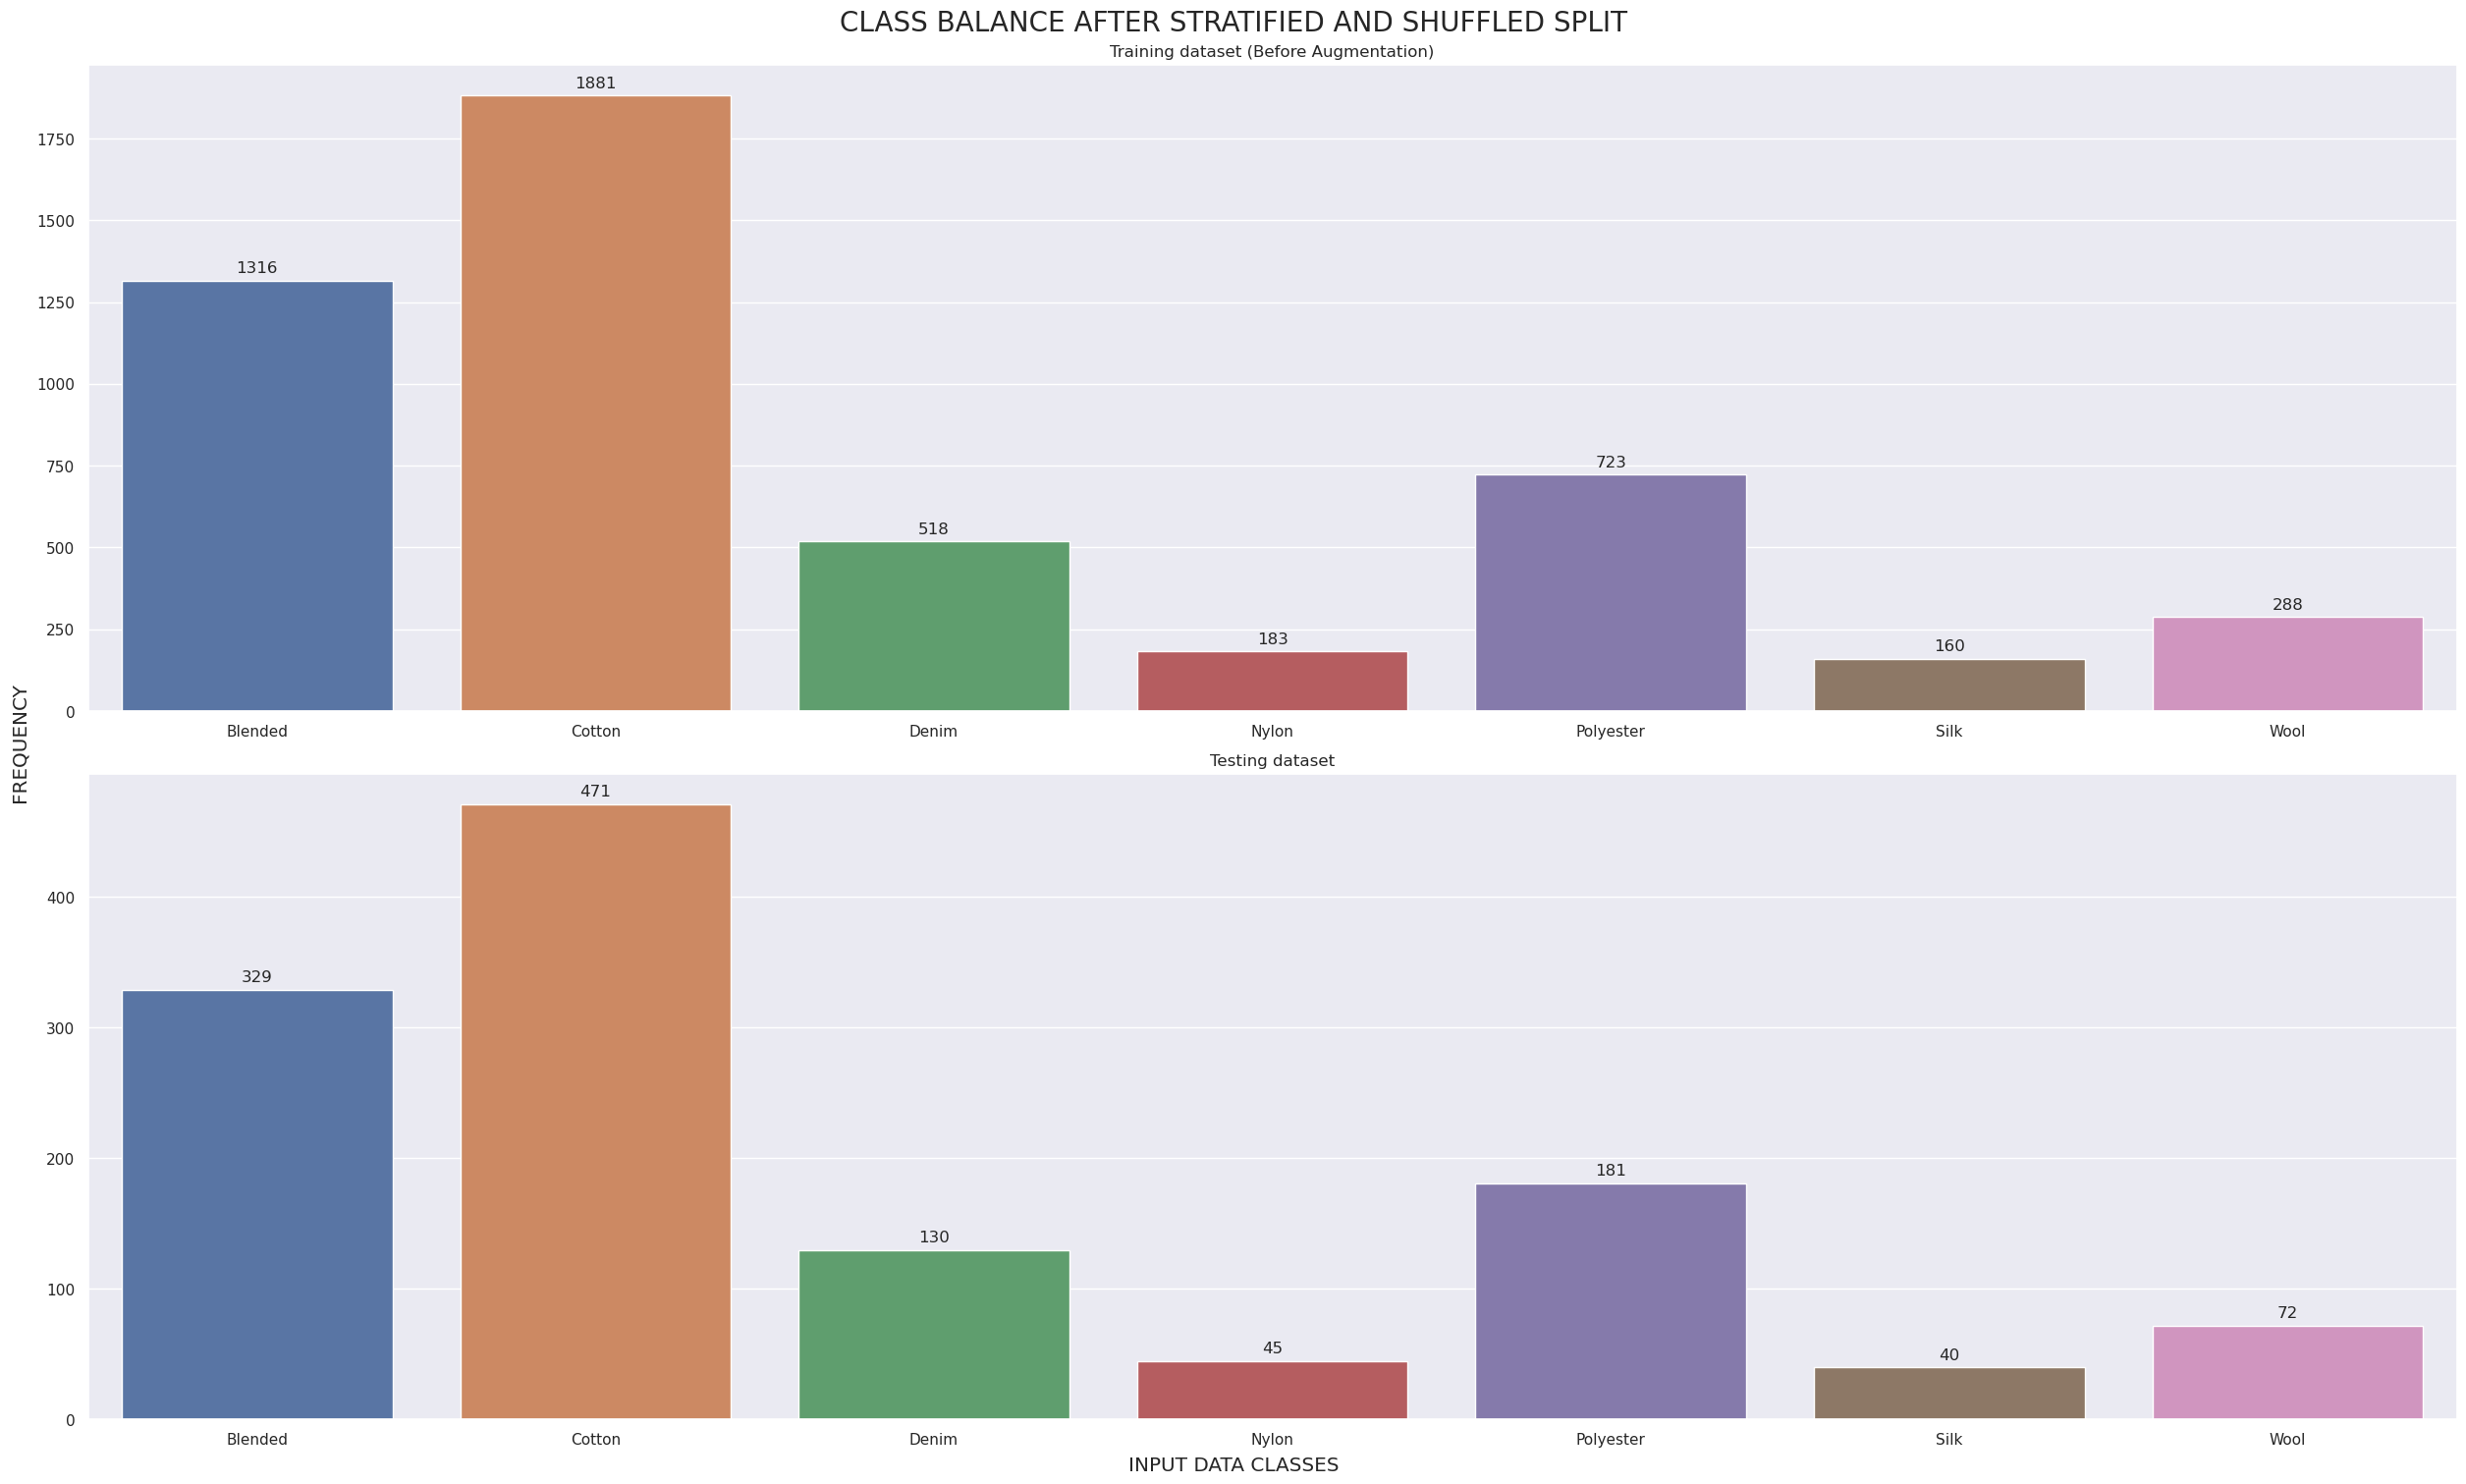

In [12]:
# Class balance after stratify split
fig, axs = plt.subplots(2, 1, figsize=(25,15), layout='constrained')
fig.suptitle('CLASS BALANCE AFTER STRATIFIED AND SHUFFLED SPLIT', fontsize=20)
fig.supxlabel('INPUT DATA CLASSES')
fig.supylabel('FREQUENCY')
axs_list = axs.flatten()

# Class count in training dataset
train_values, train_counts = np.unique(train_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[0], x=train_values, y=train_counts).set(title='Training dataset (Before Augmentation)')
ax = axs_list[0]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

# Class count in testing dataset
test_values, test_counts = np.unique(test_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[1], x=test_values, y=test_counts).set(title='Testing dataset')
ax = axs_list[1]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

In [ ]:
# Augmentation level 1
TARGET_DIRECTORY = "/kaggle/working/preprocessing/augmented/"
original_datagenerator = ImageDataGenerator(rotation_range=30,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      shear_range=0.2,
                                      zoom_range=0.1,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


for label in ["Denim", "Nylon", "Polyester", "Silk", "Wool"]:
    os.makedirs(TARGET_DIRECTORY + label)
    temp_df = train_df.loc[train_df['Label'].isin([label])]
    data_gen = original_datagenerator.flow_from_dataframe(
        dataframe = temp_df,
        save_to_dir = TARGET_DIRECTORY + label,
        x_col='Filepath',
        y_col='Label',
        target_size=(400, 400),
        interpolation='bicubic',
        color_mode='rgb',
        class_mode='categorical',
        batch_size=len(temp_df),
        seed=SEED_VALUE,
    )
    
    for val in range(len(data_gen)):
        print("Using the Geneartor to create augmented images")
        data_gen.next()

In [ ]:
# Augmentation level 2
TARGET_DIRECTORY = "/kaggle/working/preprocessing/augmented_2/"
original_datagenerator = ImageDataGenerator(rotation_range=70,
                                      width_shift_range=0.15,
                                      height_shift_range=0.25,
                                      shear_range=0.1,
                                      zoom_range=0.2,
                                      vertical_flip=True,
                                      fill_mode='nearest')


for label in ["Denim", "Nylon", "Silk", "Wool"]:
    os.makedirs(TARGET_DIRECTORY + label)
    temp_df = train_df.loc[train_df['Label'].isin([label])]
    data_gen = original_datagenerator.flow_from_dataframe(
        dataframe = temp_df,
        save_to_dir = TARGET_DIRECTORY + label,
        x_col='Filepath',
        y_col='Label',
        target_size=(400, 400),
        interpolation='bicubic',
        color_mode='rgb',
        class_mode='categorical',
        batch_size=len(temp_df),
        seed=SEED_VALUE,
    )
    
    for val in range(len(data_gen)):
        print("Using the Geneartor to create augmented images")
        data_gen.next()

In [ ]:
# Kaggle kernels have a tendency to crash when downloading large files
# Creating a downloadable link for the augmented dataset; Later this is uploaded as the input to avoid recalculation if session ends
!zip -r augmented_images.zip /kaggle/working/preprocessing
FileLink(r'augmented_images.zip')

In [13]:
# Extracting file input directory and labels for the augmented data
AUGMENTED_FILE_PATH = "/kaggle/input/the-fabrics-dataset-augmented-initial/kaggle/working/preprocessing"
input_filepaths = []
input_labels = []

for augmentation in os.listdir(AUGMENTED_FILE_PATH):
    for fabric in os.listdir(os.path.join(AUGMENTED_FILE_PATH, augmentation)):
        print("In folder {} \n".format(fabric))
        for fabric_img in os.listdir(os.path.join(AUGMENTED_FILE_PATH, augmentation, fabric)):
            if Path(fabric_img).suffix == '.png':
                src_image = os.path.join(AUGMENTED_FILE_PATH, augmentation, fabric, fabric_img)
                input_filepaths.append(src_image)
                input_labels.append(fabric)
            
            
# Creating dataframe with the filepath and respective labels
data_df_augmented = pd.DataFrame(list(zip(input_filepaths, input_labels)), columns =['Filepath', 'Label'])
temp_train_df = pd.concat([train_df, data_df_augmented])
temp_train_df = temp_train_df.reset_index(drop=True)
temp_train_df

In folder Nylon 

In folder Denim 

In folder Wool 

In folder Silk 

In folder Nylon 

In folder Polyester 

In folder Denim 

In folder Wool 

In folder Silk 



,Filepath,Label
0,/kaggle/input/the-fabrics-dataset/Cotton/1743/...,Cotton
1,/kaggle/input/the-fabrics-dataset/Blended/1784...,Blended
2,/kaggle/input/the-fabrics-dataset/Blended/1728...,Blended
3,/kaggle/input/the-fabrics-dataset/Polyester/51...,Polyester
4,/kaggle/input/the-fabrics-dataset/Cotton/1380/...,Cotton
...,...,...
8085,/kaggle/input/the-fabrics-dataset-augmented-in...,Silk
8086,/kaggle/input/the-fabrics-dataset-augmented-in...,Silk
8087,/kaggle/input/the-fabrics-dataset-augmented-in...,Silk
8088,/kaggle/input/the-fabrics-dataset-augmented-in...,Silk


In [ ]:
# Augmentation level 3
TARGET_DIRECTORY = "/kaggle/working/preprocessing/augmented_3/"
original_datagenerator = ImageDataGenerator(rotation_range=10,
                                      shear_range=0.15,
                                      zoom_range=[0.5,1.0],
                                      brightness_range=[0.2,1.0],
                                      vertical_flip=True,
                                      fill_mode='nearest')


for label in ["Nylon", "Silk", "Wool"]:
    os.makedirs(TARGET_DIRECTORY + label)
    temp_df = temp_train_df.loc[temp_train_df['Label'].isin([label])]
    data_gen = original_datagenerator.flow_from_dataframe(
        dataframe = temp_df,
        save_to_dir = TARGET_DIRECTORY + label,
        x_col='Filepath',
        y_col='Label',
        target_size=(400, 400),
        interpolation='bicubic',
        color_mode='rgb',
        class_mode='categorical',
        batch_size=len(temp_df),
        seed=SEED_VALUE,
    )
    
    for val in range(len(data_gen)):
        print("Using the Geneartor to create augmented images")
        data_gen.next()

In [ ]:
# Kaggle kernels have a tendency to crash when downloading large files; creating a downloadable link for the augmented dataset
!zip -r augmented_images_final.zip /kaggle/working/preprocessing/augmented_3
FileLink(r'augmented_images_final.zip')

In [ ]:
# Clearing up disk space

# To remove empty/non-empty folders
shutil.rmtree("/kaggle/working/preprocessing")

# To remove files
os.remove("/kaggle/working/augmented_images.zip")
os.remove("/kaggle/working/augmented_images_final.zip")

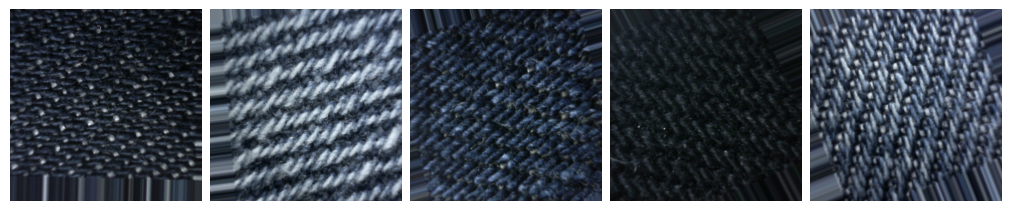

In [14]:
# Some images of Denims after augmentation
DENIM = "/kaggle/input/the-fabrics-dataset-augmented-initial/kaggle/working/preprocessing/augmented/Denim/"
plt.figure(figsize=(10, 10), layout='constrained')
for i, image in enumerate(os.listdir(DENIM)):
    if i==5:
        break;
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(plt.imread(DENIM + image))
    plt.axis('off')
plt.show()

## Merging the augmented dataset

In [15]:
# Extracting file input directory and labels for the augmented data
AUGMENTED_FILE_PATH = "/kaggle/input/the-fabrics-dataset-augmented-final/kaggle/working/preprocessing/augmented_3"
input_filepaths = []
input_labels = []

for index, fabric in enumerate(os.listdir(AUGMENTED_FILE_PATH)):
    print("In folder {} \n".format(fabric))
    for fabric_img in os.listdir(os.path.join(AUGMENTED_FILE_PATH, fabric)):
        if Path(fabric_img).suffix == '.png':
            src_image = os.path.join(AUGMENTED_FILE_PATH, fabric, fabric_img)
            input_filepaths.append(src_image)
            input_labels.append(fabric)

In folder Nylon 

In folder Wool 

In folder Silk 



In [16]:
# Creating dataframe with the filepath and respective labels
data_df_augmented = pd.DataFrame(list(zip(input_filepaths, input_labels)), columns =['Filepath', 'Label'])
data_df_augmented

,Filepath,Label
0,/kaggle/input/the-fabrics-dataset-augmented-fi...,Nylon
1,/kaggle/input/the-fabrics-dataset-augmented-fi...,Nylon
2,/kaggle/input/the-fabrics-dataset-augmented-fi...,Nylon
3,/kaggle/input/the-fabrics-dataset-augmented-fi...,Nylon
4,/kaggle/input/the-fabrics-dataset-augmented-fi...,Nylon
...,...,...
1888,/kaggle/input/the-fabrics-dataset-augmented-fi...,Silk
1889,/kaggle/input/the-fabrics-dataset-augmented-fi...,Silk
1890,/kaggle/input/the-fabrics-dataset-augmented-fi...,Silk
1891,/kaggle/input/the-fabrics-dataset-augmented-fi...,Silk


In [17]:
train_df = pd.concat([temp_train_df, data_df_augmented])
train_df = train_df.reset_index(drop=True)
train_df

,Filepath,Label
0,/kaggle/input/the-fabrics-dataset/Cotton/1743/...,Cotton
1,/kaggle/input/the-fabrics-dataset/Blended/1784...,Blended
2,/kaggle/input/the-fabrics-dataset/Blended/1728...,Blended
3,/kaggle/input/the-fabrics-dataset/Polyester/51...,Polyester
4,/kaggle/input/the-fabrics-dataset/Cotton/1380/...,Cotton
...,...,...
9978,/kaggle/input/the-fabrics-dataset-augmented-fi...,Silk
9979,/kaggle/input/the-fabrics-dataset-augmented-fi...,Silk
9980,/kaggle/input/the-fabrics-dataset-augmented-fi...,Silk
9981,/kaggle/input/the-fabrics-dataset-augmented-fi...,Silk


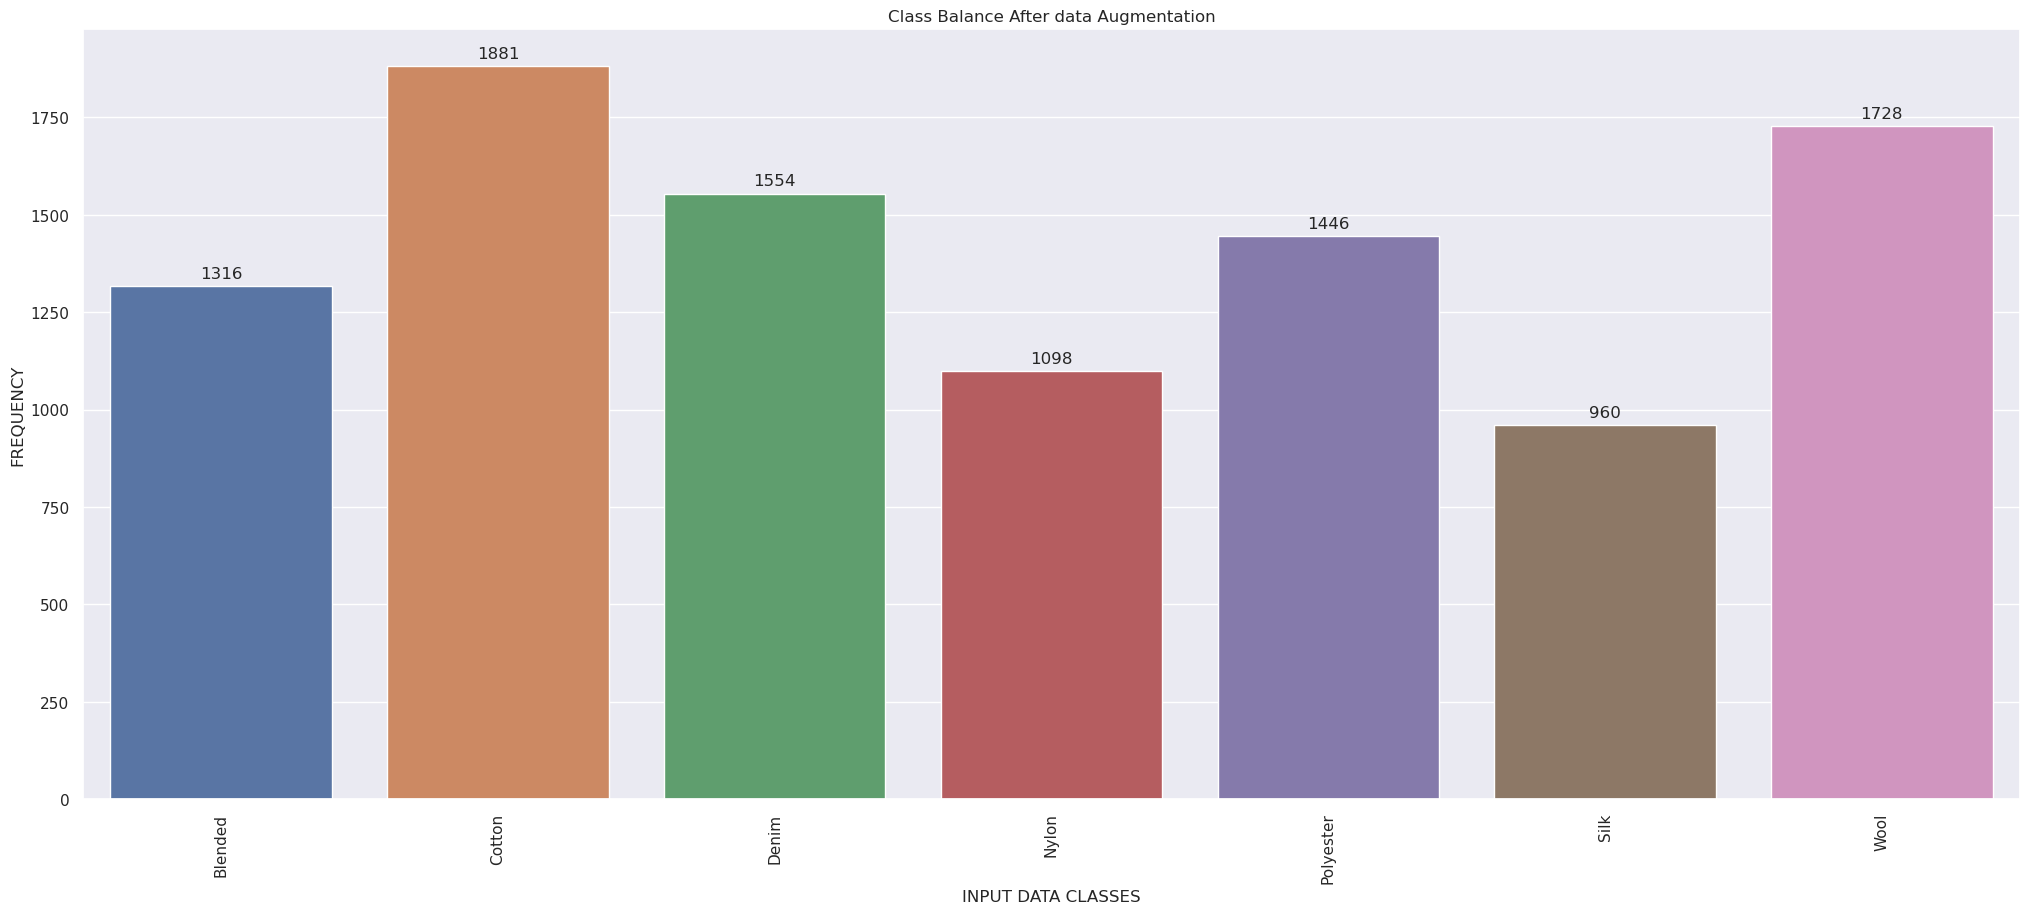

In [18]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(train_df.Label.values.tolist(), return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class Balance After data Augmentation")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

# Creating Train & Validation Datasets

In [19]:
# Splitting the data into train & test datasets with stratification ; perform a bigger split
train_df, validation_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=SEED_VALUE)

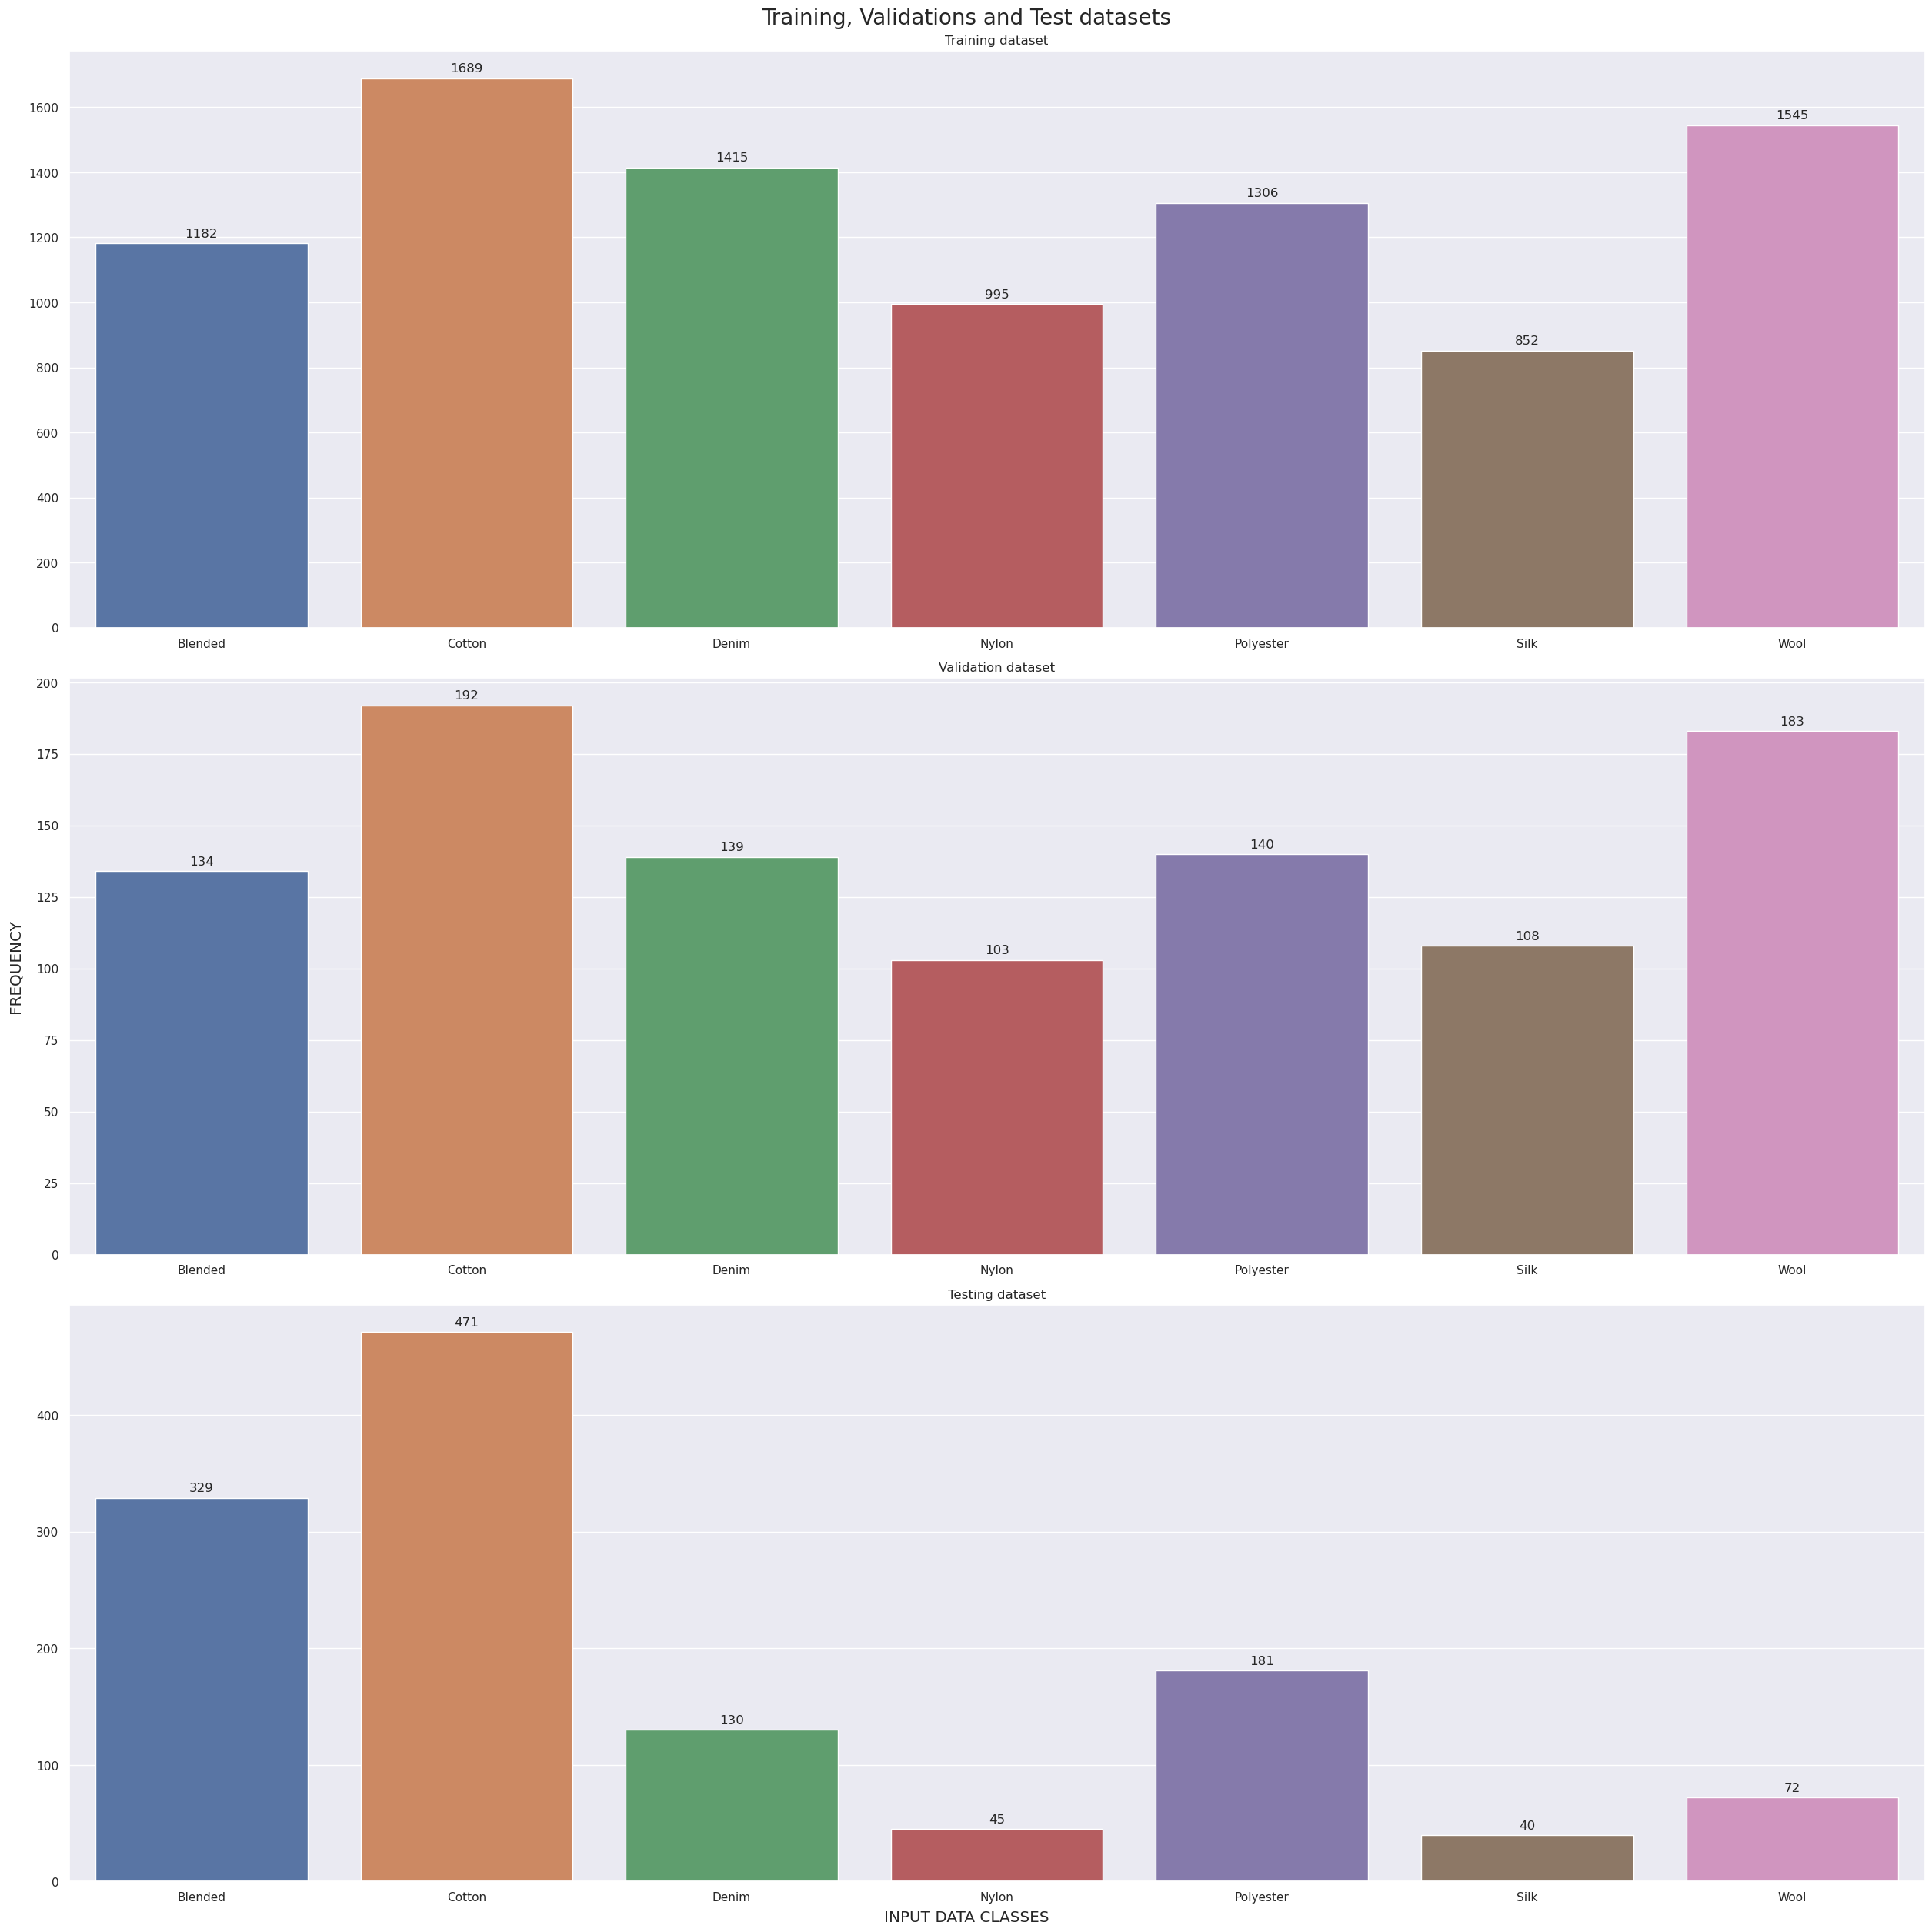

In [20]:
# Class balance after stratify split
fig, axs = plt.subplots(3, 1, figsize=(25,25), layout='constrained')
fig.suptitle('Training, Validations and Test datasets', fontsize=20)
fig.supxlabel('INPUT DATA CLASSES')
fig.supylabel('FREQUENCY')
axs_list = axs.flatten()

# Class count in training dataset
train_values, train_counts = np.unique(train_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[0], x=train_values, y=train_counts).set(title='Training dataset')
ax=ax=axs_list[0]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

# Class count in validation dataset
validation_values, validation_counts = np.unique(validation_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[1], x=validation_values, y=validation_counts).set(title='Validation dataset')
ax=ax=axs_list[1]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')
             
# Class count in testing dataset
test_values, test_counts = np.unique(test_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[2], x=test_values, y=test_counts).set(title='Testing dataset')
ax=ax=axs_list[2]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')
             
plt.show()

In [21]:
train_datagenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

training_data = train_datagenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS), # downsampling the images
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    rescale=1.0/255,
    shuffle=True,
    seed=SEED_VALUE,
)

Found 8984 validated image filenames belonging to 7 classes.


In [22]:
validation_datagenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

validation_data = validation_datagenerator.flow_from_dataframe(
    dataframe=validation_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS), # downsampling the images
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    rescale=1.0/255,
    shuffle=True,
    seed=SEED_VALUE
)

Found 999 validated image filenames belonging to 7 classes.


In [23]:
test_datagenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

test_data = test_datagenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS),
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED_VALUE
)

Found 1268 validated image filenames belonging to 7 classes.


# Model Creation

In [24]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freezing the layers
pretrained_model.trainable = False

82420632/82420632 [==============================] - 0s 0us/step


In [25]:
# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(CHECKPOINT_PATH,
                                      save_weights_only=True,
                                      monitor="val_loss",
                                      save_best_only=True)

In [26]:
early_stopping = EarlyStopping(monitor = "val_loss", restore_best_weights = True)

# Hyperparameter Tuning with Bayesian Optimization (Visualiziation through W&B)

In [ ]:
def build_model(hp):
    inputs = pretrained_model.input

    # Dense Layer 1
    x = BatchNormalization(axis=-1)(inputs)
    x = Dense(512, activation='relu')(pretrained_model.output)
    x = Dropout(hp.Float("dropout_1", 0, 0.50, step=0.25))(x)
    

    # Dense Layer 2
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(hp.Float("dropout_2", 0, 0.50, step=0.25))(x)

    # Output layer
    outputs = Dense(N_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])
    opt = hp.Choice("optimizer", values=["SGD", "Adam"])
    optimizer = SGD(learning_rate=lr)
    if opt == 'Adam':
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# reference - https://medium.com/geekculture/visualizing-hyperparameter-tuning-results-of-kerastuner-with-weights-biases-e9417055d96
# reference - https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html
class MyTuner(keras_tuner.Tuner):
    def run_trial(self, trial, training_data, validation_data, batch_size, epochs, objective):

        hp = trial.hyperparameters
        objective_name_str = objective

        ## create the model with the current trial hyperparameters
        model = self.hypermodel.build(hp)
        
        ## Initiates new run for each trial on the dashboard of Weights & Biases
        run = wandb.init(project="FabricTexture_BayesianOptimization_Augmented", config=hp.values)

        ## WandbCallback() logs all the metric data such as loss, accuracy and etc on dashboard for visualization        
        history = model.fit(
            training_data,
            validation_data=validation_data,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[
                early_stopping,
                WandbCallback()
            ]
        )


        val_loss = history.history['val_loss'][-1]
        self.oracle.update_trial(trial.trial_id, {objective_name_str:val_loss})
        run.finish()

In [ ]:
my_tuner = MyTuner(
      oracle=keras_tuner.oracles.BayesianOptimizationOracle(objective='val_loss', max_trials=12),
      hypermodel=build_model
)

my_tuner.search_space_summary()

In [ ]:
## Initiate the hyperparameter tuning process
print("Performing hyperparameter search...")
my_tuner.search(
    training_data,
    validation_data,
    batch_size=BATCH_SIZE,
    epochs=10,
    objective='val_loss'
)

## WandB dashboards

The original dashboards can be found at - [Bayesian Optimisation Dashboards](https://api.wandb.ai/links/self_thush/pazxe6bq)

### Validation Accuracies
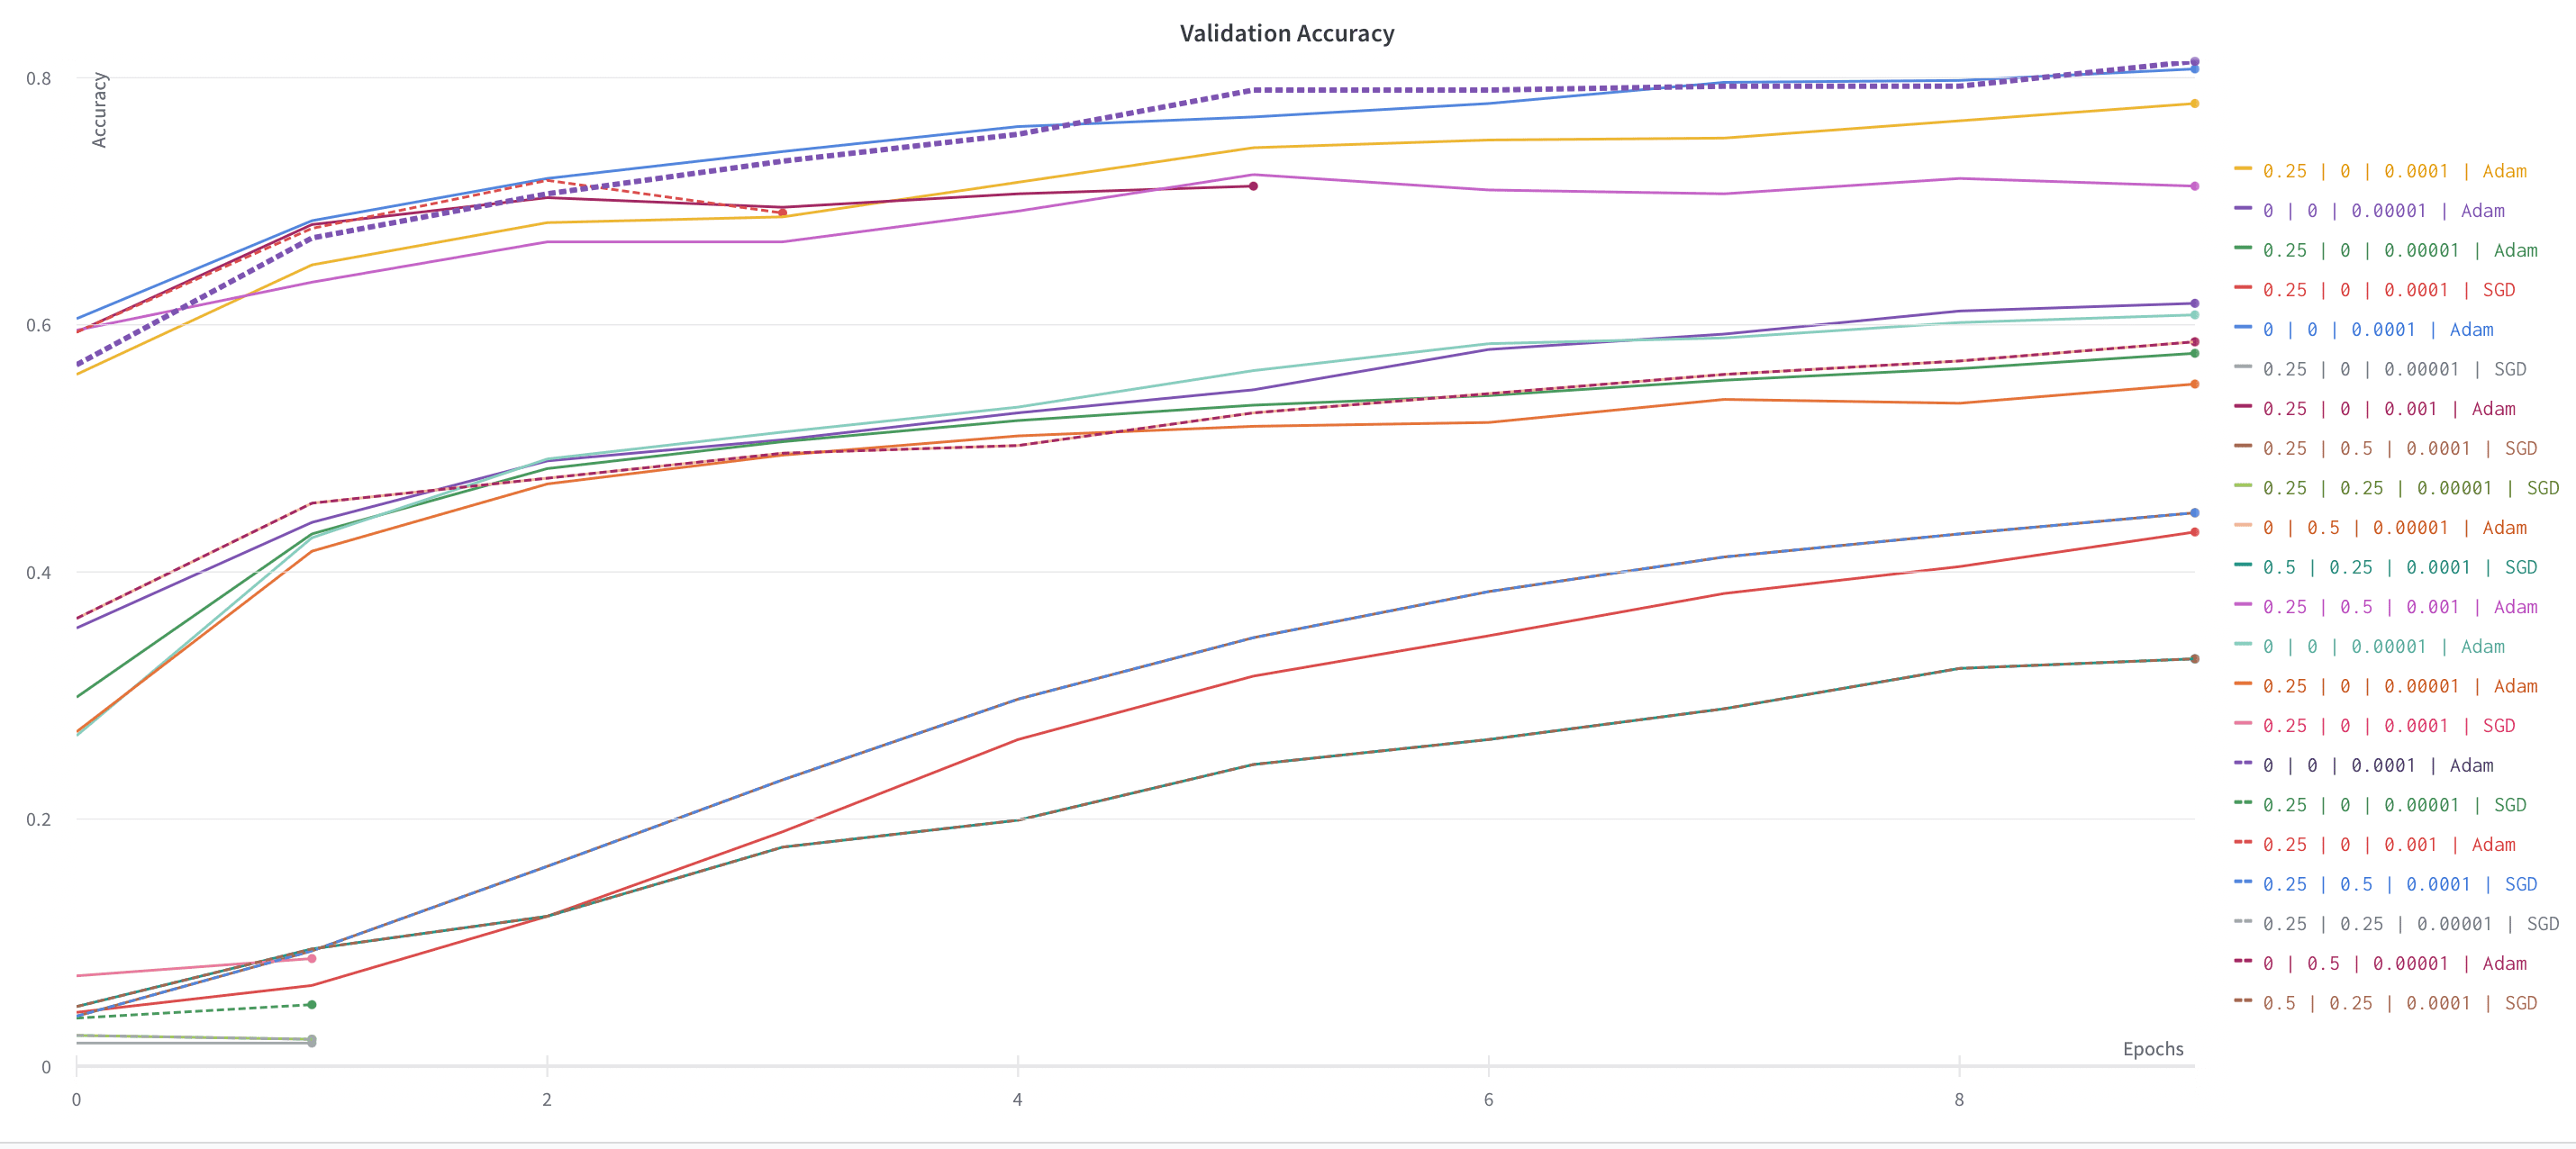

### All Charts
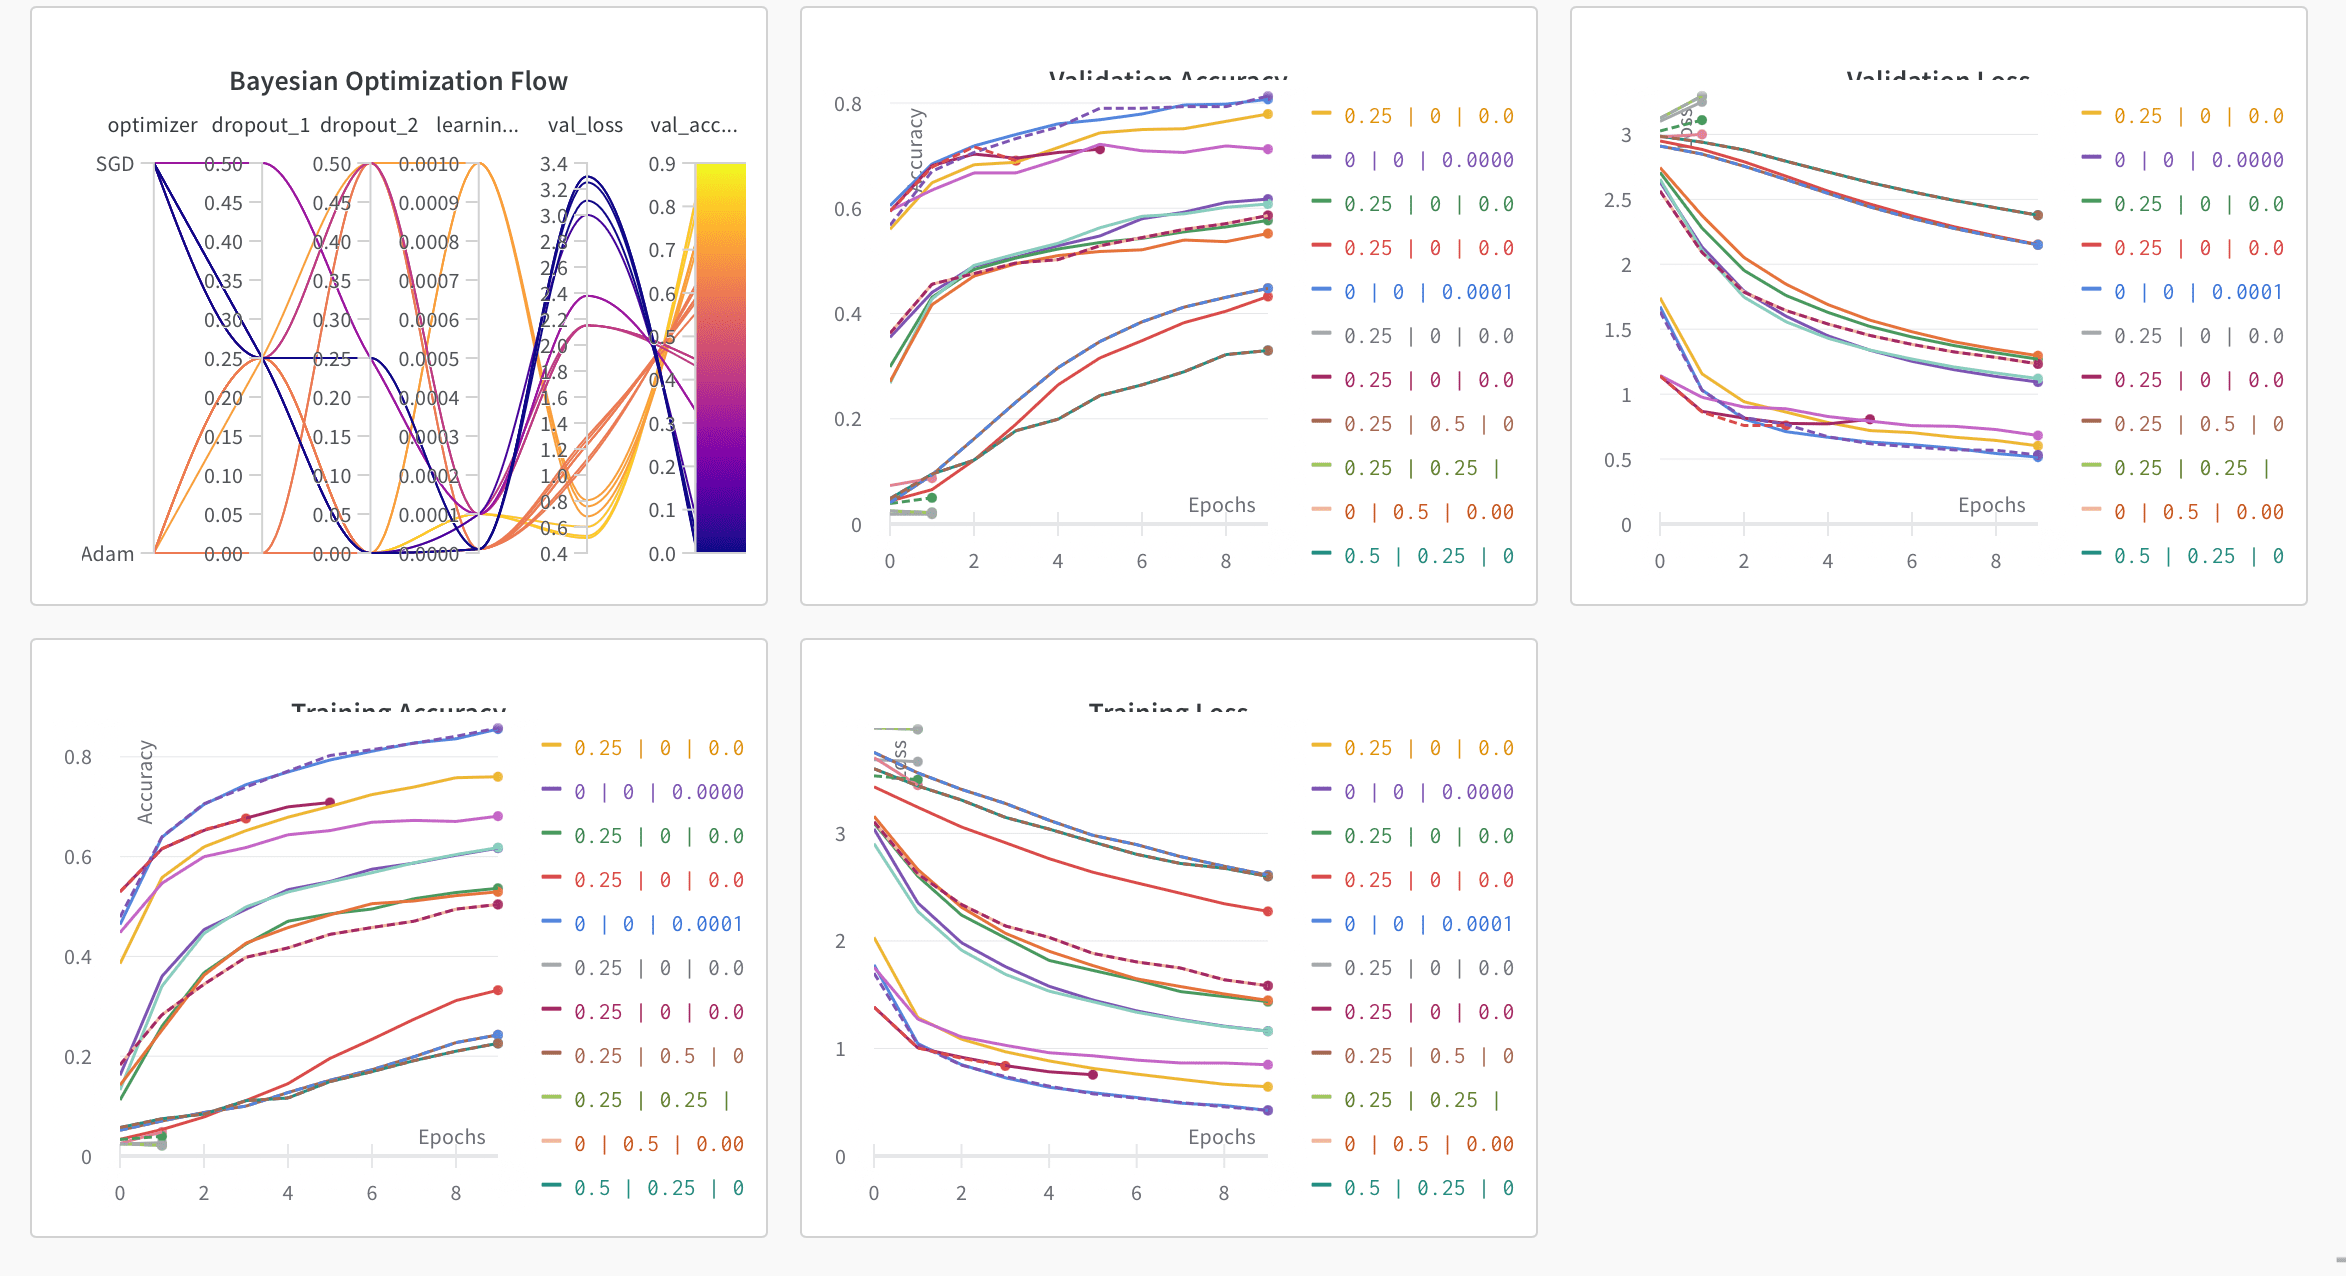

# Model training with best hyperparameters

We train the model separately in 2 sets of optimal hyperparameters found in the tuning process. The evaluation metrics for both these combinations will be displayed through WandB dashboards

1. **Combination 1**:
* dropout_1 = 0.25
* dropout_1 = 0.0
* learning_rate = 0.0001
* optimiser = Adam

2. **Combination 2**:
* dropout_1 = 0.0
* dropout_1 = 0.0
* learning_rate = 0.0001
* optimiser = Adam

In [ ]:
wandb.init(project="FabricTexture_ModelTraining_Augmented_Combo2")

In [27]:
def build_model_final():
    inputs = pretrained_model.input

    # Dense Layer 1
    x = BatchNormalization(axis=-1)(inputs)
    x = Dense(512, activation='relu')(pretrained_model.output)
    x = Dropout(0.0)(x)
    

    # Dense Layer 2
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0)(x)
    

    # Output layer
    outputs = Dense(N_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [39]:
model = build_model_final()

In [44]:
image = visualkeras.layered_view(model, legend=True)
image.save('/kaggle/working/model_representation.png')

In [45]:
image2 = visualkeras.layered_view(model, legend=True, draw_volume=False)
image2.save('/kaggle/working/model_representation2.png')

In [ ]:
logging_dir = ROOT_DIR + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logging_dir)

model = build_model_final()
history = model.fit(
    training_data,
    steps_per_epoch=len(training_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    epochs=20,
    callbacks=[
        WandbCallback(),
        tensorboard_callback,
        checkpoint_callback
    ]
)

# Visualizing of Model Performance (Confusion Matrix, Loss, ROC, Precision Curve)

In [ ]:
# Class balance after stratify split
fig, axs = plt.subplots(1, 2, figsize=(18, 9), layout='constrained')
fig.suptitle('Evaluation of Model Training', fontsize=20)
axs_list = axs.flatten()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

sns.lineplot(ax=axs_list[0], x=range(1, 31), y=accuracy,  legend='brief', label='Training Accuracy').set(title='Training & Validation Accuracies')
sns.lineplot(ax=axs_list[0], x=range(1, 31), y=val_accuracy, legend='brief', label='Validation Accuracy')
axs_list[0].set(xlabel='Epoch', ylabel='Accuracy')

sns.lineplot(ax=axs_list[1], x=range(1, 31), y=loss, legend='brief', label='Training Loss').set(title='Training & Validation Losses')
sns.lineplot(ax=axs_list[1], x=range(1, 31), y=val_loss, legend='brief', label='Validation Loss')
axs_list[1].set(xlabel='Epoch', ylabel='Loss')


plt.show()

## WandB dashboards for Model Training & Validation


**Combination 1**
The original dashboards can be found at - [Model Training with Hyperparameter Combination 1](https://api.wandb.ai/links/self_thush/5ndb5943)

**Combination 2**
The original dashboards can be found at - [Model Training with Hyperparameter Combination 2](https://api.wandb.ai/links/self_thush/qqakmds6)

# Evaluating the model against Test dataset

In [ ]:
train_acc = model.evaluate(training_data)
test_acc = model.evaluate(test_data)
print('Train: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

In [ ]:
# Predict the label of the test_images
pred_probs = model.predict(test_data)
pred = np.argmax(pred_probs, axis=1)

# Map the label
labels = (test_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
y_test = []
for i in test_data.index_array:
    y_test.append(test_df.Label.iloc[i])

In [ ]:
# ROC
wandb.log({'roc': wandb.plots.ROC(y_test, pred_probs)})

# Precision Recall
wandb.log({'pr': wandb.plots.precision_recall(y_test, pred_probs)})

# Confusion Matrix
wandb.sklearn.plot_confusion_matrix(y_test, pred)

## WandB dashboards for Model Evaluation


**Combination 1**
The original dashboards can be found at - [Model Training with Hyperparameter Combination 1](https://api.wandb.ai/links/self_thush/5ndb5943)

**Combination 2**
The original dashboards can be found at - [Model Training with Hyperparameter Combination 2](https://api.wandb.ai/links/self_thush/qqakmds6)